# Hand-in 3, Part 1: Data handling and exploration

In this first notebook you will show us how you handle data being separated over several files, as well as exploring the quality and properties of your data.

#### Section 1: bash scripting

You have downloaded a zip file containing 5 CSV files, each containing part of the data you need. First, use your bash tools to look at the headers and size of the file. What do the different files contain?

Write a bash script that concatenates the 4 data files (except the flow_criticality_data.csv file). Exlain in the markdown cell below, what each part of your script does.

**Q#1** *Explain your script here (by double clicking on this text).*

* Define that we are using bash
```bash
#! /bin/bash
```

* Quick explanation of what the bashscript does
```bash
# Joining the files
#
# Usage "./collect_data.sh 
```
* Make temp1.csv containing half the data -t, means the file is comma seperated, -a1 and -a2 means that it will also print any unpairable line -oauto means that it will automatically format the data
```bash
join -t, -a1 -a2 -oauto energy_demand_data.csv exchange_data.csv > temp1.csv
```
* Make temp2.csv containing the other half of data
```bash
join -t, -a1 -a2 -oauto renewable_production_data.csv generator_production_data.csv > temp2.csv
```
* Combine the temp files, to one whole file
```bash
join -t, -a1 -a2 -oauto temp1.csv temp2.csv > joined_data.csv
```
* Clean up by removing the temp files
```bash
rm temp1.csv
rm temp2.csv
```


## Section 2: Visualizing the data
Here you will plot the resulting data file from the previous section, and plot it in order to identify missing data and see if you can already draw some conclusions on the data.

* *Hint: remember the hint given in Exc.13.3, on how to find out if your data contains NaN values*

In [221]:
# Importing the packages we need
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
import numpy as np
import scipy

In [2]:
# Import of the data created with the bash script
data  = pd.read_csv('joined_data.csv')

<IPython.core.display.Javascript object>


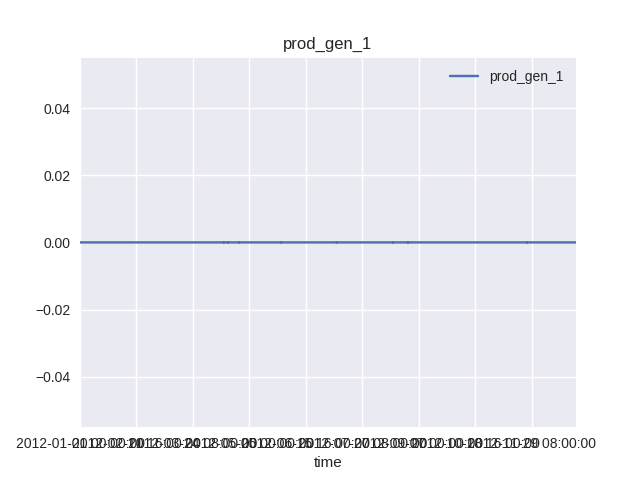

/home/student/.local/lib/python3.5/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


<IPython.core.display.Javascript object>


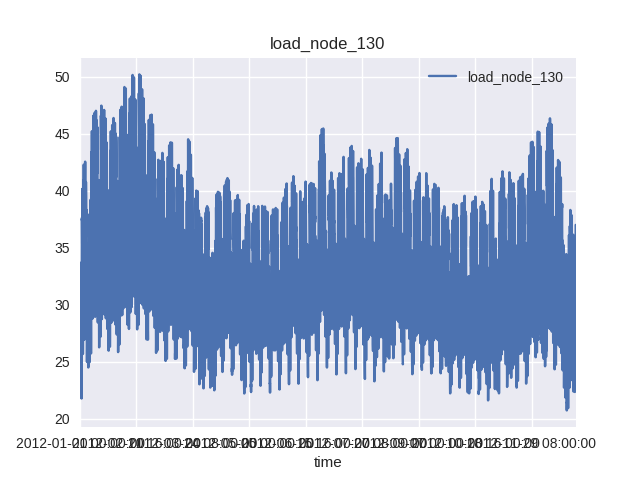

<IPython.core.display.Javascript object>


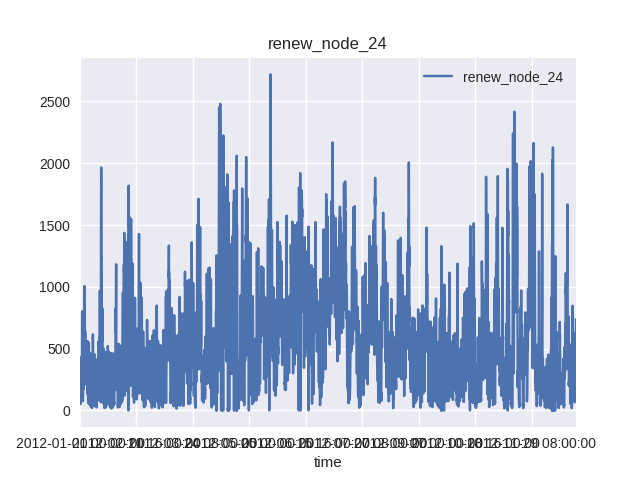

In [3]:
# Simple plots showing a small pick of our data

data.plot(x='time',y='prod_gen_1',title='prod_gen_1')
data.plot(x='time',y='load_node_130',title='load_node_130')
data.plot(x='time',y='renew_node_24',title='renew_node_24')



**would it be practical to plot all possible scatter plots (scatter matrix)?**

*Not really, unless you use a cluster to compute the data, as there are way too many datapoints and columns*

**Q#2** For this data, what is the reasonable approach to dealing with the NaN values? Why?

*As there is no directly observable pattern, interpolation does not seem like a good aproach. Therefor we will be dropping the NaN's.*


In [226]:
# Removal of NaN's


print("Total number of NaN's before removal: " +str(data.isnull().sum().sum()))
# Drop any row containing any NaN's
data_nona = data.dropna(how='any')
print("Total number of NaN's after removal: " +str(data_nona.isnull().sum().sum()))

Total number of NaN's before removal: 1711
Total number of NaN's after removal: 0


### Feature reduction
Since you must reduce the amount of sensors, you need to find out which ones you can get rid of. 

**Q#3** Why would PCA be useful for this?

*It shows you which components are principal for your data. Thereby showing which sensors are impacting the overall data more*

*With that in mind, you can narrow down the amount of sensors, used to generate data. Obviously you will loose some data, but choosing the correct amount of components, you can get pretty close to the full data*

NaN's in data set: 0


<IPython.core.display.Javascript object>


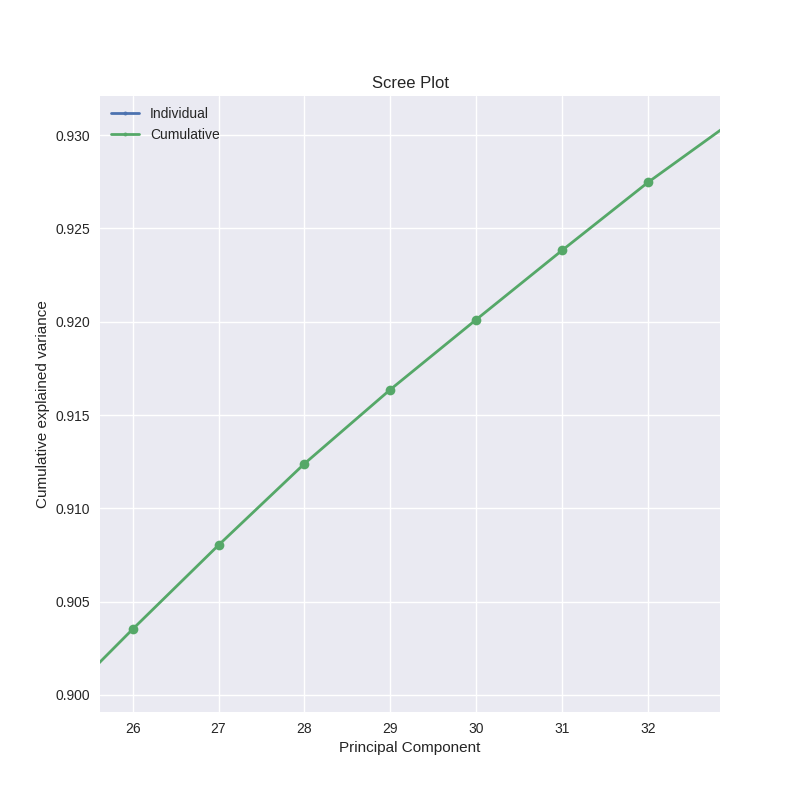

In [239]:
from sklearn.decomposition import PCA

# Removal of the time column, as this is not usable in math
datanotime = data_nona.drop('time',1)

# First we standardize the data
data_stand = (datanotime - datanotime.mean()) / datanotime.std()

# The standardization created a lot of NaN's
# These came from dividing by zero, as a lot of the prod_gen sensors had only zero's
data_stand = data_stand.dropna(axis=1,how='all')

print("NaN's in data set: " + str(data_stand.isnull().sum().sum()))
    
# Then instantiate the data, and make the fit
comp=data_stand.shape[1]
pca = PCA(n_components=comp)
pca_data=pca.fit(data_stand)

# Plotting the explained variance
fig = plt.figure(figsize=(8,8))
sing_vals = np.arange(comp) + 1
plt.plot(sing_vals, pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative explained variance')
plt.plot(sing_vals, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=2)

plt.legend(['Individual','Cumulative'], loc='best', borderpad=0.3, 
            shadow=False,
            markerscale=0.4)

# Saving the pca components
data_components = pca.components_

In [241]:
# Find the number of components needed to explain 90% of the variance
for i in range(0,comp):
    if pca.explained_variance_ratio_.cumsum()[i] >= 0.9:
        print("with " +str(i+1) +" components you explain " + str(pca.explained_variance_ratio_.cumsum()[i]*100) +"%" )
        new_comp=(i+1)
        break;


with 26 components you explain 90.3526618632%


### Scree plot
**Q#4** How many principal components do you need to explain 90 % of the variance

26 pricipal components would be needed to explain more than 90% of the variance

26 components will explain 90.35% of the variance

### Clustering
You want to reduce the amount of field sensors to 20. You should now have from the previous question, an array with all your loading vectors (pca.components\_), one vector per principal component, with 137 elements (one per each sensor). Use clustering to group sensors that behave the same. 

**Q#5** How would you choose which sensors in each cluster you should keep?

In [246]:
from sklearn.cluster import KMeans

# Slice the components we need. We take 26 as that gives us about 90% explained variance
slice=data_components[0:new_comp]

# Instanciate and fit the clusters
kmeans = KMeans(n_clusters=20, n_init=200, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, n_jobs=2)
kmeans.fit(slice.T)
cluster_pred = kmeans.predict(slice.T)

# Prints the predicted clusters
print(cluster_pred)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 13 18 19  1  0 17 13  1 13 15  1  4 17  1
  4 15  1  5 13  8 18 17  6 16 14  1 16  1 14  1 17  1 14  5 14  1  1 11 11
 11 12 17 12 17 15 17 18 15  6 19 10  8  9 13 13  1  8 10  4 19  3  0  7  7
  8  9 10 10 10  4  9 10  4  9 19 10  8  8  8  4  7  7  2 13]


In [248]:
import scipy

# Make a pandas dataframe of our sensors, and the clusters they belong to
clust = pd.DataFrame(data_stand.columns, columns=['sensors'])
clust['cluster'] = cluster_pred

# calculate the distance from a sensor to the cluster center
temp = []
for i in range(slice.T.shape[0]):
    A=slice.T[i]
    B=kmeans.cluster_centers_[clust.cluster[i]]
    temp.append(scipy.spatial.distance.euclidean(A, B))
clust['dist_to_center'] = temp

# Find the sensor in a cluster that is closest to the cluster centers
x=0
data_reduced = []
sensor_cluster = []
while x <= max(clust.cluster):
    temp_min = 100000
    temp_ind = 0
    for i in range(slice.shape[1]):
        if clust.cluster[i] == x:
            if clust.dist_to_center[i] < temp_min:
                temp_min = clust.dist_to_center[i]
                temp_ind = i
    data_reduced.append(clust.sensors[temp_ind])
    x+=1

# Make a new pandas dataframe witht the reduced sensor list
data_reduced = pd.DataFrame(data_reduced, columns=['sensors'])

# Sort the list of clusters by their distance to the center, for manual check up
sorted_clust = clust.sort_values(by=['dist_to_center'])

# For manual check
#print(data_reduced.to_string(index=False))
#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#    print(sorted_clust)

### Save your chosen sensors

Now that you have chosen 20 sensors which are representative of your data, create a DataFrame that contains these sensors. You can save them to csv file using the code in the following cell.

In [249]:
# Assuming of course that your reduced data set is called data_reduced
data_reduced.to_csv('reduced_field_data.csv')
data_reduced


,sensors
0,prod_gen_19
1,load_node_153
2,prod_gen_50
3,prod_gen_18
4,prod_gen_41
5,export_node_59
6,renew_node_143
7,prod_gen_44
8,prod_gen_39
9,prod_gen_23
